# SOG Model Freshwater Chemistry Analysis
### Sections
   1. [Local Functions](#Local-Functions)
   2. [Load SOG Data](#Load-SOG-Data)
   3. [TA regressions](#TA-regressions)
   4. [Fraser River Buoy pH Data](#Fraser-River-Buoy-pH-Data)
   5. [Freshwater DIC:TA scenarios](#Freshwater-DIC:TA-scenarios)
   6. [Flow Record Results](#Flow-Record-Results)
   7. [Timeseries Results](#Timeseries-Results)
   8. [Salinity Averages](#Salinity-Averages)

In [260]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import statsmodels.api as sm
import SOG_loader
import carbonate
import yaml
import os
import gsw
import cmocean
from salishsea_tools import utilities, nc_tools
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy import signal
from scipy.io import loadmat
from matplotlib import gridspec, cm
from matplotlib.dates import DateFormatter

%matplotlib inline

## Local Functions

In [3]:
def export_TA_record(TA_record):
    """
    """
    
    # Create new forcing file
    Fraser_file = pd.read_csv(
        '/ocean/bmoorema/research/SOG/SOG-forcing/rivers/Fraser_total_31May2013.dat',
        delim_whitespace=True, names=['year', 'month', 'day', 'flow'],
    )
    Fraser_file = Fraser_file.join(pd.DataFrame(TA_record, columns=['TA']))
    #Fraser.to_csv('/ocean/bmoorema/research/SOG/SOG-forcing/rivers/FraserTA.dat', sep=' ', header=False, index=False)

In [4]:
def parse_run_path(path, keys):
    """
    """
    
    params = {}
    string = os.path.split(path)[1]
    params['year'] = string.split('_')[0]
    chemstr = string.split(keys[0], maxsplit=1)[1].split(keys[1])
    params[keys[0]] = chemstr[0]
    params[keys[1]] = chemstr[1]
    
    return params

In [5]:
def load_SOG_dict(results, path):
    """
    """
    
    # Parse run path
    params = parse_run_path(path, ['TA', 'DICTA'])
    year, TA, DICTA = params['year'], params['TA'], params['DICTA']
    
    # Initialize run dict
    results[DICTA][TA][year] = {}
    
    # Load timeseries
    TS_phys = SOG_loader.load_TS(os.path.join(path, 'timeseries/std_phys_SOG.out'))
    TS_chem = SOG_loader.load_TS(os.path.join(path, 'timeseries/std_chem_SOG.out'))
    TS_bio = SOG_loader.load_TS(os.path.join(path, 'timeseries/std_bio_SOG.out'))
    
    # Extract physics fields
    results[DICTA][TA][year]['t'] = TS_phys['3 m avg temperature']                 # in situ temperature [deg C]
    results[DICTA][TA][year]['SP'] = TS_phys['3 m avg salinity']                   # practical salinity  [PSS 78]
    
    # Calculate and assign TEOS-10 properties
    results[DICTA][TA][year]['SR'] = gsw.conversions.SR_from_SP(results[DICTA][TA][year]['SP'])
    results[DICTA][TA][year]['CT'] = gsw.conversions.CT_from_t(results[DICTA][TA][year]['SR'], results[DICTA][TA][year]['t'], 0)
    results[DICTA][TA][year]['rho'] = gsw.density.rho(results[DICTA][TA][year]['SR'], results[DICTA][TA][year]['CT'], 0)
    
    # Extract bio and chem fields
    results[DICTA][TA][year]['NO3'] = TS_bio['3 m avg nitrate concentration'] * 1e3 / results[DICTA][TA][year]['rho']
    results[DICTA][TA][year]['NH4'] = TS_bio['3 m avg ammonium concentration'] * 1e3 / results[DICTA][TA][year]['rho']
    results[DICTA][TA][year]['Si'] = TS_bio['3 m avg silicon concentration'] * 1e3 / results[DICTA][TA][year]['rho']
    results[DICTA][TA][year]['DIC'] = TS_chem['3 m avg DIC concentration'] * 1e3 / results[DICTA][TA][year]['rho']
    results[DICTA][TA][year]['TA'] = TS_chem['3 m avg alkalinity'] * 1e3 / results[DICTA][TA][year]['rho']
    
    # Calculate CO2 parameters
    CO2 = carbonate.calc_carbonate(
        [results[DICTA][TA][year]['TA'], results[DICTA][TA][year]['DIC']],         # [TA, DIC]
        (results[DICTA][TA][year]['NO3'] + results[DICTA][TA][year]['NH4']) / 16,  # total phosphate (estimated from N)
        results[DICTA][TA][year]['Si'],                                            # dissolved silica
        results[DICTA][TA][year]['t'],                                             # in situ temperature
        results[DICTA][TA][year]['SP'],                                            # practical salinity
        0,                                                                         # pressure
        params=['TA', 'TC'],
    )
    
    # Assign CO2 parameters
    results[DICTA][TA][year]['pH'] = CO2['pH']                                     # pH [total scale]
    results[DICTA][TA][year]['pCO2'] = CO2['pCO2']                                 # CO2 partial pressure [uatm]
    results[DICTA][TA][year]['OmegaA'] = CO2['OmegaA']                             # aragonite saturation stat
    
    return results

## Load SOG Data

In [160]:
# Load GRL2016 data
SOG_TA = {}
data = np.loadtxt('/home/bmoorema/Desktop/grl2016.raw')
SOG_TA['crid'] = data[:, 0]
SOG_TA['stn'] = data[:, 3]
SOG_TA['mnth'] = data[:, 4]
SOG_TA['day'] = data[:, 5]
SOG_TA['S'] = data[:, 10]
SOG_TA['alk'] = data[:, 15]
SOG_TA['alk_qf'] = data[:, 16]

In [7]:
# Load Fraser Record
Fraser = {}
data = loadmat('/ocean/rich/home/metro/fraser/FRASER.mat')
Fraser['flow'] = data['fraser'][0][0][2].flatten()
Fraser['flow_filter'] = signal.filtfilt(*signal.butter(2, 0.1), Fraser['flow'])
Fraser['dQdt'] = np.diff(Fraser['flow_filter'])/24
Fraser['dQdt'] = np.append(Fraser['dQdt'][0], Fraser['dQdt'])
Fraser['date'] = [
    datetime.fromordinal(int(mtime[0]) - 366) +
    timedelta(days=float(mtime)%1)
    for mtime in data['fraser'][0][0][1]
]

In [8]:
# Load buoy pH record
buoy = {}
data = loadmat('/ocean/rich/home/metro/ecbuoy/matlab/ECBUOY.mat')
buoy['date'] = [
    datetime.fromordinal(int(mtime[0])) + timedelta(days=mtime[0]%1) - timedelta(days = 366)
    for mtime in data['ecbuoy'][0][0][4]
]
buoy['T'] = data['ecbuoy'][0][0][5]
buoy['S'] = gsw.conversions.SP_from_C(data['ecbuoy'][0][0][6] * 1e-3, buoy['T'], 0)
buoy['pH'] = carbonate.FindpHOnAllScales(data['ecbuoy'][0][0][16], buoy['T'], buoy['S'], 0, scale='NBS')

In [9]:
# Load SOG results
with open('/ocean/bmoorema/research/SOG/SOG-runsets/river_chemistry/run_list.yaml', 'r') as f:
    run_list = yaml.load(f)
SOG_results = {
    '1032': {'250': {}, '500': {}, '750': {}, '1000': {}, '1250': {}, 'var': {}},
    '1089': {'250': {}, '500': {}, '750': {}, '1000': {}, '1250': {}, 'var': {}},
    '1226': {'250': {}, '500': {}, '750': {}, '1000': {}, '1250': {}, 'var': {}},
}
bar = utilities.statusbar('Loading ...')
for path in bar(run_list['run_list']):
    SOG_results = load_SOG_dict(SOG_results, path)

Loading ... 100% (216 of 216) |#####################################################################|Time: 0:04:25


In [119]:
# SOG river temp
RiverTemp = 2.5 + (np.arange(365) - 52.8) * (19.3 - 2.5) / (232.9 - 52.8)
RiverTemp[233:] = 19.3 + (np.arange(365)[233:] - 232.9) * (2.5 - 19.3) / (334.4 - 232.9)
RiverTemp[:53] = 2.5
RiverTemp[335:] = 2.5

## TA regressions

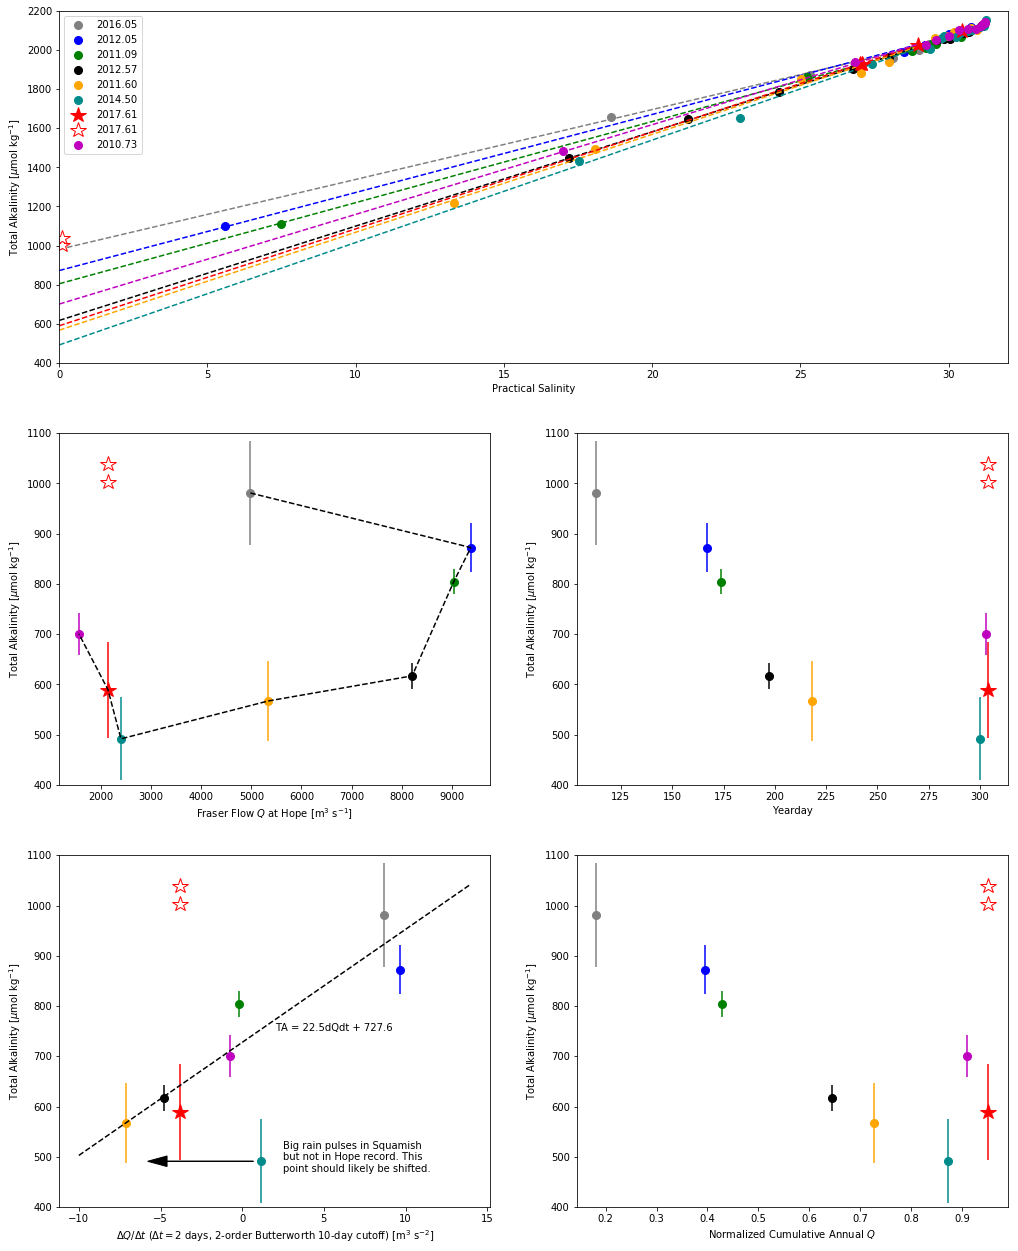

In [165]:
# Cruises to plot
cruises = [2010.73, 2011.09, 2011.60, 2012.05, 2012.57, 2014.50, 2016.05, 2017.61, 2017.61]
stations = [39.5, 42., 39.5, 42., 39.5, 42., 42., 1.5, 0.5]
colors = ['gray', 'b', 'g', 'k', 'orange', 'darkcyan', 'm', 'r', 'r']

cruises = [2016.05, 2012.05, 2011.09, 2012.57, 2011.60, 2014.50, 2017.61, 2017.61, 2010.73]
stations = [42., 42., 42., 39.5, 39.5, 42., 1.5, 0.5, 39.5]
colors = ['gray', 'b', 'g', 'k', 'orange', 'darkcyan', 'r', 'r', 'm']

# Make figure
fig = plt.figure(figsize=(17, 22))
gs = gridspec.GridSpec(3, 2)
axs = [fig.add_subplot(gs[0, :])]
axs.extend([fig.add_subplot(gs[1, col]) for col in range(2)])
axs.extend([fig.add_subplot(gs[2, col]) for col in range(2)])
axs[0].set_xlim([0, 32])
axs[0].set_ylim([400, 2200])
axs[0].set_xlabel('Practical Salinity')
axs[0].set_ylabel('Total Alkalinity [$\mu$mol kg$^{-1}$]')
labels = [
    'Fraser Flow $Q$ at Hope [m$^3$ s$^{-1}$]',
    'Yearday',
    '$\Delta Q/\Delta t$ ($\Delta t = 2$ days, 2-order Butterworth 10-day cutoff) [m$^{3}$ s$^{-2}$]',
    'Normalized Cumulative Annual $Q$',
]
for ax, label in zip(axs[1:], labels):
    ax.set_ylim([400, 1100])
    ax.set_xlabel(label)
    ax.set_ylabel('Total Alkalinity [$\mu$mol kg$^{-1}$]')

x_reg, y_reg = [], []
x_hist, y_hist = [], []

# ------------- Loop through cruises ------------------------
for cruise, station, color in zip(cruises, stations, colors):
    
    # Symbols
    if color is 'r':
        marker = '*'
        size = 16
    else:
        marker = 'o'
        size = 8
    
    # Index
    index = (
        (SOG_TA['crid'] == cruise) &
        (SOG_TA['stn'] == station) &
        ((SOG_TA['alk_qf'] == 2) | (SOG_TA['alk_qf'] == 6))
    )
    
    # Regressions
    if station == 0.5:
        facecolor = 'w'
    else:
        facecolor = color
        S_fit = sm.OLS(SOG_TA['alk'][index], sm.add_constant(SOG_TA['S'][index])).fit()
    
    # Flow metrics
    month, day = int(SOG_TA['mnth'][index][0]), int(SOG_TA['day'][index][0])
    flowindex = [
        abs(np.array(Fraser['date']) - datetime(int(cruise), *yearday)).argmin()
        for yearday in [[month, day], [1, 1], [12, 31]]
    ]
    intQ = Fraser['flow'][flowindex[1]: flowindex[0]].sum()/Fraser['flow'][flowindex[1]: flowindex[2]].sum()
    
    # Salinity Regression Plot
    axs[0].plot(
        SOG_TA['S'][index], SOG_TA['alk'][index],
        marker=marker, color=color,
        markersize=size, markerfacecolor=facecolor,
        linestyle='', label=f'{cruise:.2f}',
    )
    if station != 0.5:
        axs[0].plot(np.arange(30), S_fit.params[1] * np.arange(30) + S_fit.params[0], linestyle='--', color=color)
    
    # Endmember Plots
    metrics = [
        Fraser['flow'][flowindex[0]],
        (Fraser['date'][flowindex[0]] - Fraser['date'][flowindex[1]]).days,
        Fraser['dQdt'][flowindex[0]], intQ,
    ]
    for i, ax, x in zip(range(4), axs[1:], metrics):
        if station == 0.5:
            ax.plot(
                x*np.ones(sum(index)), SOG_TA['alk'][index],
                marker=marker, color=color,
                markerfacecolor=facecolor, markersize=size, linestyle='',
            )
        else:
            ax.plot(x, S_fit.params[0], marker=marker, color=color, markerfacecolor=facecolor, markersize=size)
            ax.errorbar(x, S_fit.params[0], S_fit.conf_int()[0][1] - S_fit.params[0], color=color)
            if i == 2 and cruise != 2014.50:
                x_reg.append(x)
                y_reg.append(S_fit.params[0])
            elif i == 0:
                x_hist.append(x)
                y_hist.append(S_fit.params[0])

axs[1].plot(x_hist, y_hist, 'k--')
dQdt_fit = sm.OLS(np.array(y_reg), sm.add_constant(np.array(x_reg))).fit()
axs[3].plot(np.arange(-10, 15), dQdt_fit.params[1] * np.arange(-10, 15) + dQdt_fit.params[0], 'k--')
axs[3].text(0.5, 0.5, f'TA = {dQdt_fit.params[1]:.1f}dQdt + {dQdt_fit.params[0]:.1f}', transform=axs[3].transAxes)
axs[3].text(0.52, 0.1, 'Big rain pulses in Squamish\nbut not in Hope record. This\npoint should likely be shifted.', transform=axs[3].transAxes)
axs[3].arrow(0.45, 0.13, -0.2, 0, head_width=0.03, fc='k', transform=axs[3].transAxes)
axs[0].legend()
plt.show()

## Fraser River Buoy pH Data

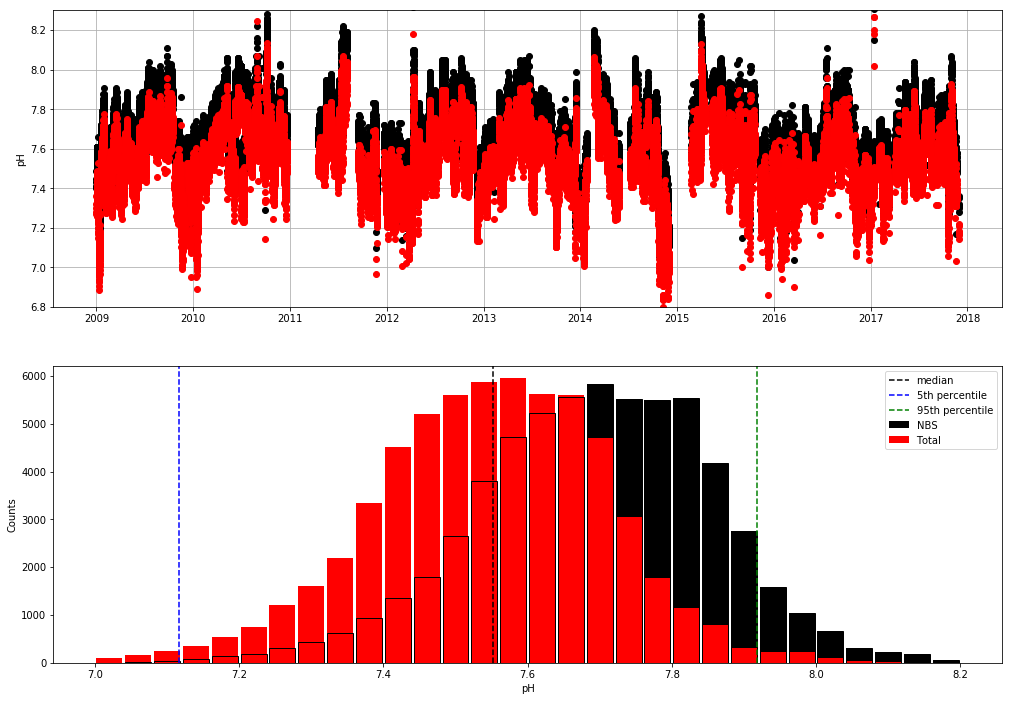

In [60]:
# pH Stats
median = np.nanmedian(buoy['pH']['total'])
percentile_5 = np.nanpercentile(buoy['pH']['total'], 1)
percentile_95 = np.nanpercentile(buoy['pH']['total'], 99)

# Make Figure
fig, ax = plt.subplots(2, 1, figsize=(17, 12))
ax[0].plot(buoy['date'], buoy['pH']['NBS'], 'ko')
ax[0].plot(buoy['date'], buoy['pH']['total'], 'ro')
ax[0].set_ylim([6.8, 8.3])
ax[0].set_ylabel('pH')
ax[0].grid()

ax[1].hist(buoy['pH']['NBS'][~np.isnan(buoy['pH']['NBS'])], bins=30, range=[7, 8.2], rwidth=0.9, color='k', label='NBS')
ax[1].hist(buoy['pH']['total'][~np.isnan(buoy['pH']['total'])], bins=30, range=[7, 8.2], rwidth=0.9, color='r', label='Total')
ax[1].hist(buoy['pH']['NBS'][~np.isnan(buoy['pH']['NBS'])], bins=30, range=[7, 8.2], rwidth=0.9, color='k', fill=False)
ax[1].plot([median, median], [0, 6200], 'k--', label='median')
ax[1].plot([percentile_5, percentile_5], [0, 6200], 'b--', label='5th percentile')
ax[1].plot([percentile_95, percentile_95], [0, 6200], 'g--', label='95th percentile')
ax[1].set_ylim([0, 6200])
ax[1].set_xlabel('pH')
ax[1].set_ylabel('Counts')
ax[1].legend()
plt.show()

## Freshwater DIC:TA scenarios
Plot model freshwater DIC:TA as determined by TA and pH

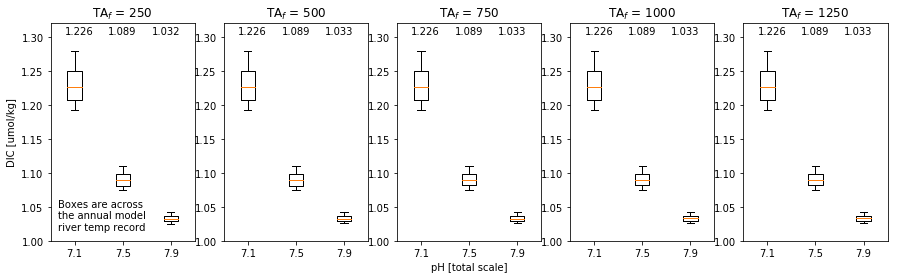

In [168]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4))
axs[0].set_ylabel('DIC [umol/kg]')
axs[2].set_xlabel('pH [total scale]')
axs[0].text(0.05, 0.05, 'Boxes are across\nthe annual model\nriver temp record', transform=axs[0].transAxes)
pHs = [7.1, 7.5, 7.9]
TAs = [250, 500, 750, 1000, 1250]
lims = [
    [150, 405],
    [400, 755],
    [700, 1055],
    [975, 1330],
    [1275, 1630],
]
for ax, lim, TA in zip(axs, lims, TAs):
    CO2 = []
    for pH, pos in zip(pHs, [0.1, 0.4, 0.7]):
        data = carbonate.calc_carbonate([TA, pH], 0, 0, np.arange(2.5, 19.4, 0.1), 0, 0, params=['TA', 'pH'])
        CO2.append(data['TC']/TA)
        ax.text(pos, 0.95, f'{np.nanmedian(data["TC"]/TA):.3f}', transform=ax.transAxes)
    ax.boxplot(CO2, labels=pHs)
    ax.set_ylim([1, 1.32])
    ax.set_title(f'TA$_f$ = {TA}')
plt.show()

## Flow Record Results
### Figure summary (see next plots below)
   1. 2012 has the largest freshet throughout the record and 2010 has the smallest (top).
   2. Flow dependent TA (dQ/dt) is actually the largest in 2007 due to the rapid rate of change in flow (centre).
   3. Flow dependence (dQ/dt) causes stronger estuarine pH declines leading up to the freshet than estuarine pH increases following the freshet since the pre-freshet dQ/dt slopes are stronger (bottom). This may not be a publishable result though since our fit to dQ/dt uses so few data extrapolated so far away from S=0. However I did add a hysteresis curve to the TA endmember vs Q plot above which supports our dQ/dt relation further (still probably not enough for serious discussion in the paper).

In [257]:
# Define color palette
colors = [cm.get_cmap(cmocean.cm.haline)(pos/11) for pos in range(12)]
years = np.arange(2001, 2013)[np.array(Freshet).argsort()]

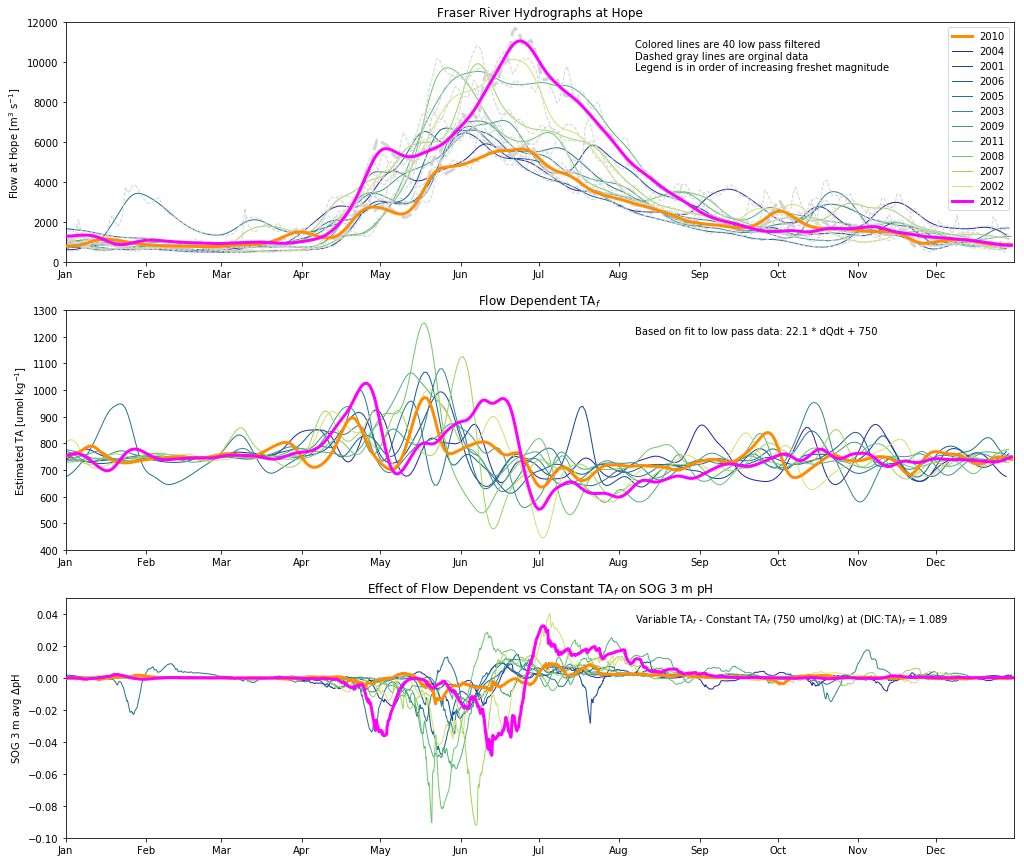

In [368]:
# Make figure
fig, axs = plt.subplots(3, 1, figsize=(17, 15))

axs[0].set_ylim([0, 12000])
axs[1].set_ylim([400, 1300])
axs[2].set_ylim([-0.1, 0.05])
axs[0].set_ylabel('Flow at Hope [m$^{3}$ s$^{-1}$]')
axs[1].set_ylabel('Estimated TA [umol kg$^{-1}$]')
axs[2].set_ylabel('SOG 3 m avg $\Delta$pH')
axs[0].set_title('Fraser River Hydrographs at Hope')
axs[1].set_title('Flow Dependent TA$_f$')
axs[2].set_title('Effect of Flow Dependent vs Constant TA$_f$ on SOG 3 m pH')

axs[0].text(
    0.6, 0.8, 'Colored lines are 40 low pass filtered\nDashed gray lines are orginal data\nLegend is in order of increasing freshet magnitude',
    transform=axs[0].transAxes,
)
axs[1].text(0.6, 0.9, 'Based on fit to low pass data: 22.1 * dQdt + 750', transform=axs[1].transAxes)
axs[2].text(0.6, 0.9, 'Variable TA$_f$ - Constant TA$_f$ (750 umol/kg) at (DIC:TA)$_f$ = 1.089', transform=axs[2].transAxes)

# Loop through years
Freshet = []
for year, color in zip(years, colors):
    linecolor = color
    linewidth = 1
    zorder = 0
    if year == 2010:
        linecolor = 'darkorange'
        linewidth = 3
        zorder = 10
    elif year == 2012:
        linecolor = 'magenta'
        linewidth = 3
        zorder = 10
    flowindex = [
        abs(np.array(Fraser['date']) - datetime(year, 1, 1) - timedelta(days=yearday)).argmin()
        for yearday in [0, 365]
    ]
    date = (
        np.array(Fraser['date'])[flowindex[0]: flowindex[1]] -
        timedelta(days=(int(year) - 2012)*365)
    )
    Freshet.append(Fraser['flow_filter'][flowindex[0]: flowindex[1]].max())
    axs[0].plot(date, Fraser['flow'][flowindex[0]: flowindex[1]], '--', color='lightgrey', linewidth=linewidth)
    axs[0].plot(date,
        Fraser['flow_filter'][flowindex[0]: flowindex[1]],
            '-', color=linecolor, label=f'{year:d}', linewidth=linewidth, zorder=zorder,
    )
    axs[1].plot(
        date, 22.1*Fraser['dQdt'][flowindex[0]: flowindex[1]] + 750, '-',
        color=linecolor, linewidth=linewidth, zorder=zorder,
    )
    
    date = (
        SOG_results['1089']['750'][str(year)]['pH'].date.values.astype('datetime64[s]').astype(datetime) -
        timedelta(days=(int(year) - 2012)*365)
    )
    axs[2].plot(
        date,
        SOG_results['1089']['var'][str(year)]['pH'] -
        SOG_results['1089']['750'][str(year)]['pH'],
        color=linecolor, linewidth=linewidth, zorder=zorder,
    )
for ax in axs:
    ax.set_xlim(['2012 Jan 1', '2012 Dec 31'])
    ax.xaxis.set_major_formatter(DateFormatter('%b'))
axs[0].legend()
plt.show()

## Timeseries Results

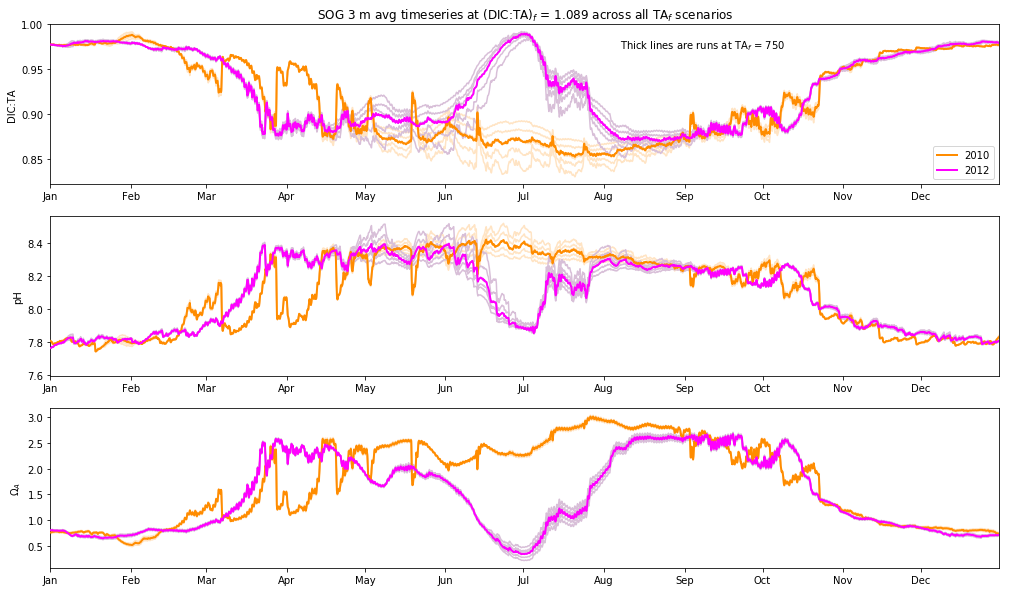

In [372]:
fig, axs = plt.subplots(3, 1, figsize=(17, 10))
for year, linestyle, color, bgcolor in zip(['2010', '2012'], ['-', '-'], ['darkorange', 'magenta'], ['bisque', 'thistle']):
    date = (
        SOG_results['1089']['750'][year]['pH'].date.values.astype('datetime64[s]').astype(datetime) -
        timedelta(days=(int(year) - 2012)*365)
    )
    for TA in TAs:
        axs[0].plot(
            date, SOG_results['1089'][TA][year]['DIC'] /
            SOG_results['1089'][TA][year]['TA'],
            color=bgcolor, linestyle=linestyle
        )
        axs[1].plot(date, SOG_results['1089'][TA][year]['pH'], color=bgcolor, linestyle=linestyle)
        axs[2].plot(date, SOG_results['1089'][TA][year]['OmegaA'], color=bgcolor, linestyle=linestyle)
        
    axs[0].plot(
            date, SOG_results['1089']['750'][year]['DIC'] /
            SOG_results['1089']['750'][year]['TA'],
            color=color, linestyle=linestyle, linewidth=2, zorder=10, label=str(year),
    )
    axs[1].plot(date, SOG_results['1089']['750'][year]['pH'], color=color, linestyle=linestyle, linewidth=2, zorder=10)
    axs[2].plot(date, SOG_results['1089']['750'][year]['OmegaA'], color=color, linestyle=linestyle, linewidth=2, zorder=10)

for ax, label in zip(axs, ['DIC:TA', 'pH', '$\Omega_A$']):
    ax.set_xlim(['2012 Jan 1', '2012 Dec 31'])
    ax.xaxis.set_major_formatter(DateFormatter('%b'))
    ax.set_ylabel(label)

axs[0].legend(loc=4)
axs[0].text(0.6, 0.85, 'Thick lines are runs at TA$_f$ = 750', transform=axs[0].transAxes)
axs[0].set_title('SOG 3 m avg timeseries at (DIC:TA)$_f$ = 1.089 across all TA$_f$ scenarios')
plt.show()

## Salinity Averages

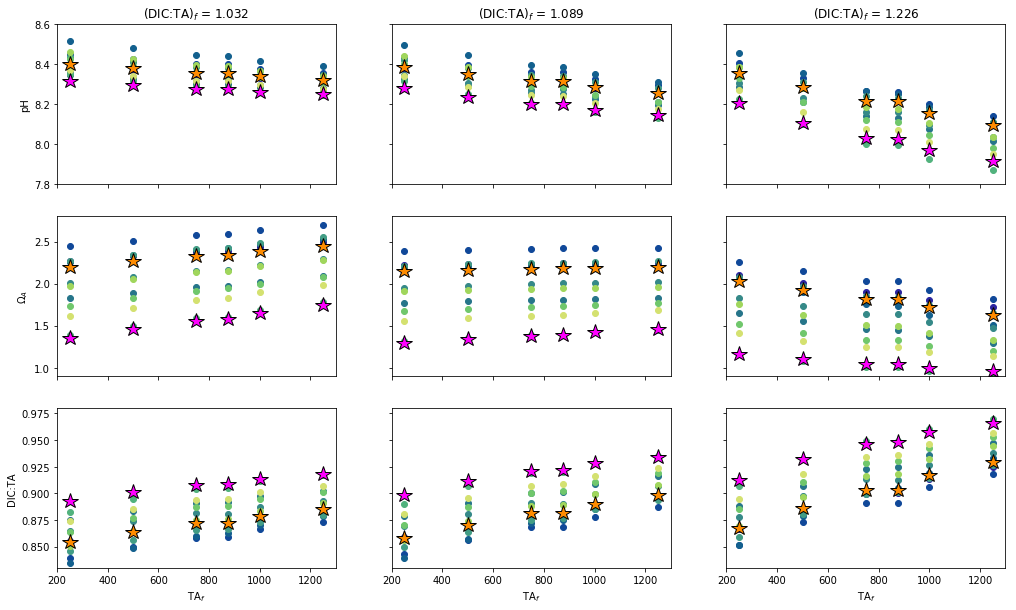

In [344]:
# Extract keys
#years = list(SOG_results['1032']['var'].keys())
TAs = list(SOG_results['1032'].keys())
DICTAs = list(SOG_results.keys())

# Make Figure
fig, axs = plt.subplots(3, 3, figsize=(17, 10))
lims = [[7.8, 8.6], [0.9, 2.8], [0.83, 0.98]]
params = ['pH', 'OmegaA', 'DICTA']

# Loop through plots
for row, param, lim, label in zip(axs, params, lims, ['pH', '$\Omega_A$', 'DIC:TA']):
    for ax, DICTA in zip(row, DICTAs):
        ax.set_ylim(lim)
        if param is 'pH':
            ax.set_title(f'(DIC:TA)$_f$ = {int(DICTA)*1e-3:.3f}')
        if param is not 'DICTA':
            ax.xaxis.set_ticklabels('')
        else:
            ax.set_xlabel('TA$_f$')
        if DICTA is not '1032':
            ax.yaxis.set_ticklabels('')
        else:
            ax.set_ylabel(label)
        for TA in TAs:
            if TA is 'var':
                x = 875
            else:
                x = int(TA)
            for year, freshet, color in zip(years, Freshet, colors):
                marker = 'o'
                markersize = 6
                markercolor = color
                markeredgecolor = color
                zorder = 0
                if year == 2010 or year == 2012:
                    marker = '*'
                    markersize = 16
                    markeredgecolor = 'k'
                    zorder = 10
                    if year == 2010:
                        markercolor = 'darkorange'
                    elif year == 2012:
                        markercolor = 'magenta'
                index = SOG_results[DICTA][TA][str(year)]['SP'] < 20
                if param is 'pH':
                    y = SOG_results[DICTA][TA][str(year)]['pH'][index]
                elif param is 'OmegaA':
                    y = SOG_results[DICTA][TA][str(year)]['OmegaA'][index]
                elif param is 'DICTA':
                    y = (SOG_results[DICTA][TA][str(year)]['DIC'][index]/SOG_results[DICTA][TA][str(year)]['TA'][index])
                ax.plot(
                    x, y.mean(),
                    marker=marker, color=markercolor, markeredgecolor=markeredgecolor,
                    markersize=markersize, zorder=zorder,
                )
plt.show()